https://discourse.pymc.io/t/beta-process-or-truncated-indian-buffet-process-factor-analysis-in-the-vein-of-the-dirichlet-process-example/1180

In [1]:
%pylab inline
import pymc3 as pm
import theano.tensor as tt

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


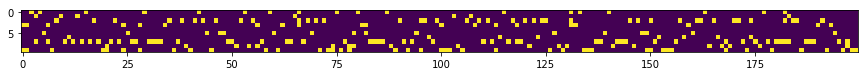

In [3]:
# Data generation
# 100 observations, each produced from a linear combination of 10 latent features
# Binary indicator array (100x10) indicating which latent features are "on" for every observation
# Beta process prior over the binary indicator array
a = 5
b = 10
K = 10
ndata = 200
data_p = np.random.beta(a / K, b * (K - 1) / K, size=(1, K))
# Bernoulli indicator array of latent features for all observations
data_Z = np.zeros((ndata, K))

for i in range(ndata):
    tmp = np.random.binomial(n=1, p=data_p)
    # make sure each role there is at least one feature activated
    while tmp.sum() == 0:
        tmp = np.random.binomial(n=1, p=data_p)
    data_Z[i, :] = tmp

_, ax = plt.subplots(1, 1, figsize=(15, 3))
ax.imshow(data_Z.T);

In [4]:
# The latent features, pulled from a Normal distribution
latent_features_data = np.random.normal(loc=5, scale=2, size=(10, 1))
# Multiply the latent features and indicator array
# Observations are linear combinations of latent features, so sum along the features axis
data = np.dot(data_Z, latent_features_data) + np.random.normal(loc=0, scale=1, size=100)

In [5]:
# Normalized data:
# data = data-data.mean()

In [6]:
# Use Gamma random variables to pull the sparse Beta draws
with pm.Model() as model:
    # Params for Beta distribution over factor probabilities
    a = pm.Gamma("a", 1, 1)
    b = pm.Gamma("b", 1, 1)
    p = pm.Beta("p", a/K, b*(K-1)/K, shape=(1, K))
    # Bernoulli indicator matrix of which factors are "on" for every observation
    Z = pm.Bernoulli("Z", p=p, shape=(ndata, K))
    # Latent factors - 10 of them
    factors = pm.Normal("factors", mu=0., sd=10., shape=(1, K))
    # Observations are linear combinations of the factors
    equation = tt.dot(Z, factors.T)
    sd = pm.HalfCauchy("sd", 0.5)
    obs = pm.Normal("obs", mu=equation, sd=sd, observed=data)

    tr = pm.sample(tune=1000, draws=1000)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [sd_log__, factors, p_logodds__, b_log__, a_log__]
>BinaryGibbsMetropolis: [Z]
100%|██████████| 2000/2000 [16:55<00:00,  1.97it/s]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


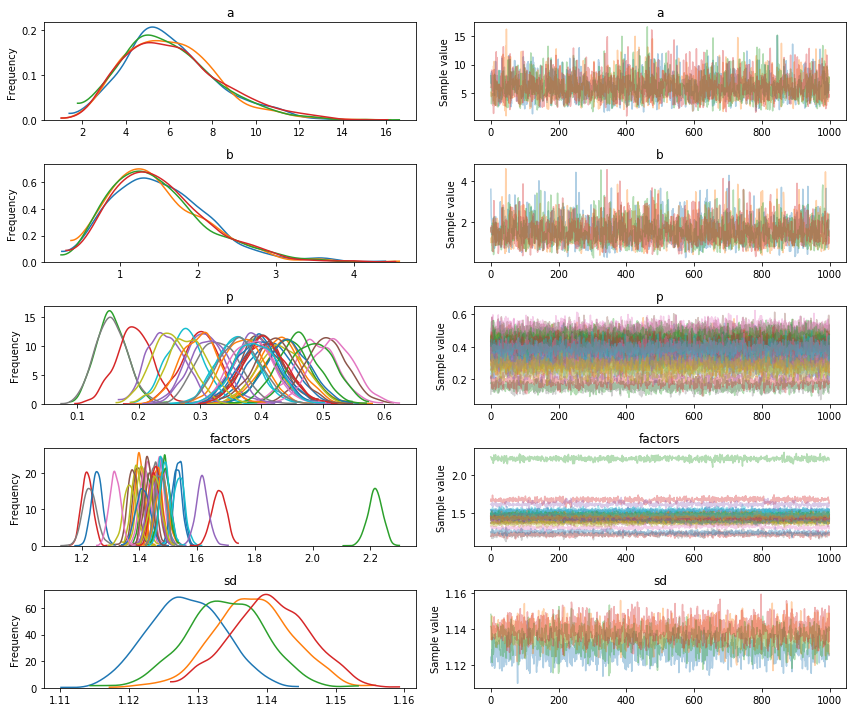

In [7]:
pm.traceplot(tr, varnames=['a', 'b', 'p', 'factors', 'sd']);

In [8]:
Z_post = tr.get_values(varname='Z', combine=False)
np.shape(Z_post[0])

(1000, 200, 10)

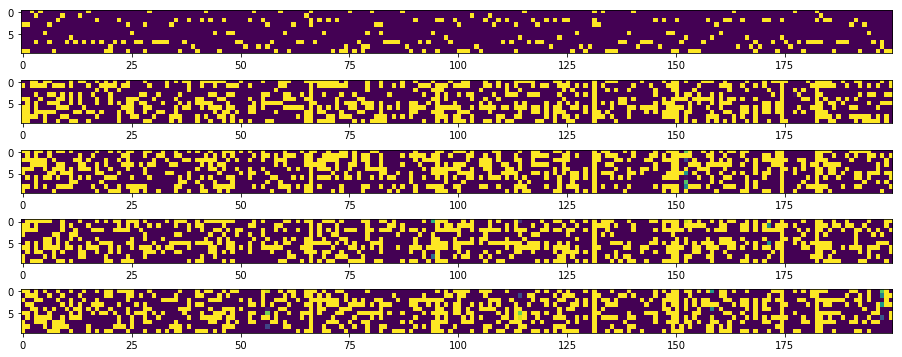

In [9]:
_, ax = plt.subplots(5, 1, figsize=(15, 5))
ax[0].imshow(data_Z.T)
for i, zpost in enumerate(Z_post):
    ax[i+1].imshow(zpost.mean(axis=0).T)
plt.tight_layout();

In [12]:
n=10
# Use Gamma random variables to pull the sparse Beta draws
with pm.Model() as model:
    # Params for Beta distribution over factor probabilities
    a = pm.Gamma("a", 1, 1)
    b = pm.Gamma("b", 1, 1)
    p = pm.Beta("p", a / K, b * (K - 1) / K, shape=(1, K))
    # Bernoulli indicator matrix of which factors are "on" for every observation
    a1 = pm.Gamma('a1', alpha=p / n, beta=1, shape=(ndata, K))
    a2 = pm.Gamma("a2", alpha=(1 - p) / n, beta=1, shape=(ndata, K))
    Z = pm.Deterministic("Z", a1 / (a1 + a2))
    # Latent factors - 10 of them
    factors = pm.Normal("factors", mu=0, sd=10, shape=(K, 1))
    # Observations are linear combinations of the factors
    equation = tt.dot(Z, factors)
    sd = pm.HalfCauchy("sd", 0.5)
    obs = pm.Normal("obs", mu=equation, sd=sd, observed=data)

In [13]:
with model:
    map1 = pm.find_MAP()

logp = nan, ||grad|| = 0: 100%|██████████| 177/177 [00:00<00:00, 864.02it/s]          


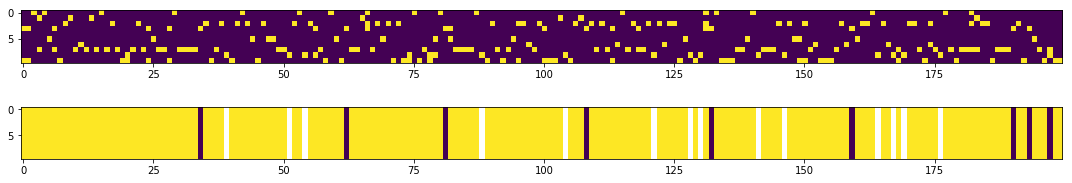

In [14]:
_, ax = plt.subplots(2, 1, figsize=(15, 3))
ax[0].imshow(data_Z.T)
ax[1].imshow(map1['Z'].T)
plt.tight_layout();

In [ ]:
map1['p']

In [ ]:
data_p

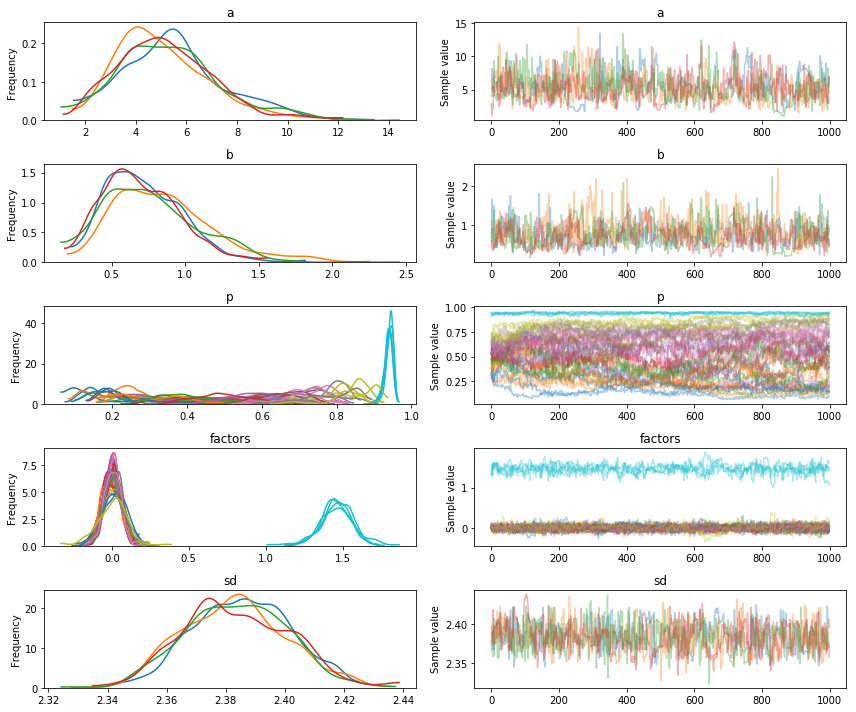

In [17]:
pm.traceplot(tr, varnames=['a', 'b', 'p', 'factors', 'sd']);